# Steps

We are gonna extract some meaningful information from medical diagnostic forms which is available in pdf files.
- Step 1: Convert pdf to image using **pdf2image** library
- Step 2: Preprocess the image (Apply **adaptive thresholding using OpenCV2**)
- Step 3: Extracting text from image by passing it through **tesseract OCR engine**
- Step 4: Finding useful information from text using **RegEx**

In [1]:
# importing necessary libraries
from pdf2image import convert_from_path
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
import cv2
import re
from PIL.PpmImagePlugin import PpmImageFile # used as type hint
from typing import Dict # used as type hint

# Setting required paths related to library functions
POPPLER_PATH = r"C:\poppler-24.02.0\Library\bin"
TESSERACT_ENGINE_PATH = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
pytesseract.pytesseract.tesseract_cmd = TESSERACT_ENGINE_PATH

In [2]:
# Path of prescription_doc file
DOC_PATH = r"D:\Projects\medical-diagonosis-extraction\Project\pdf_1.pdf"

In [3]:
# Converting pdf to images (function returns a PIL Image object)
pages = convert_from_path(DOC_PATH, poppler_path=POPPLER_PATH)
pages

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>]

In [ ]:
# Lets visualize our image
# pages[0].show() -> this PIL show() function opens image in a new window
plt.figure(figsize=(6,8))
plt.imshow(pages[0])
plt.axis(False)
plt.title("Image converted from PDF")
plt.show()

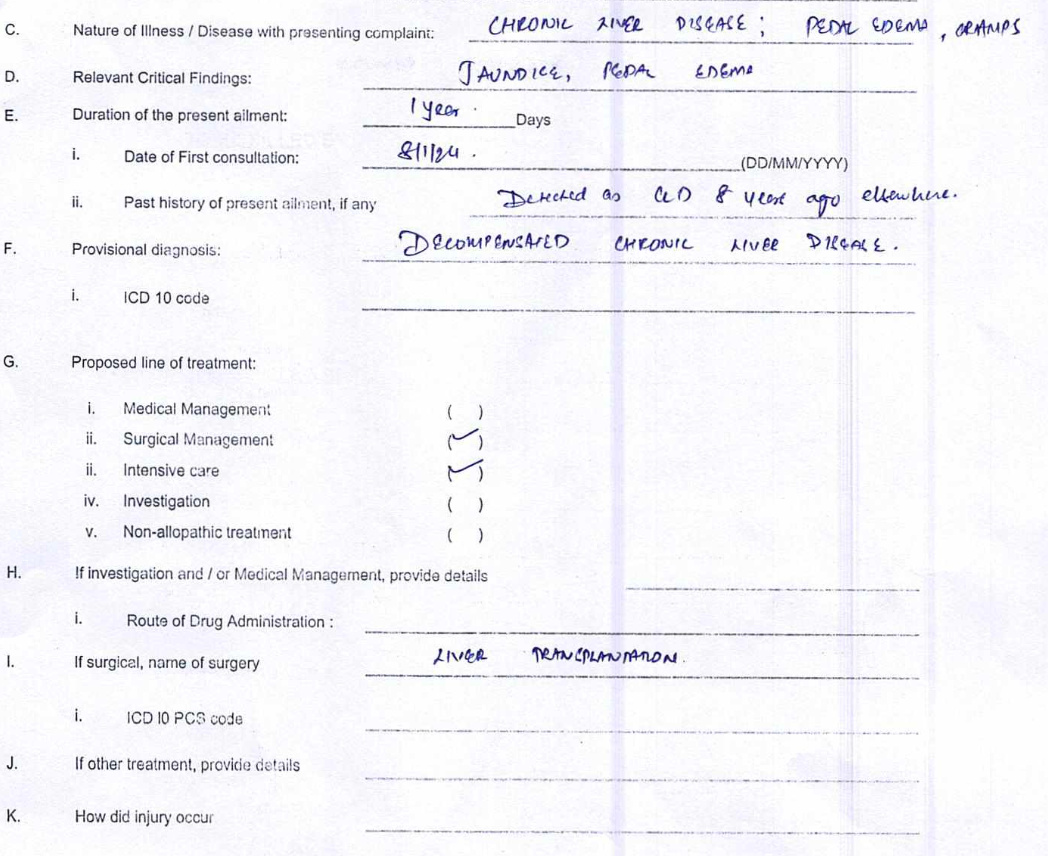

In [ ]:
# Extract text from image using pytesseract
text = pytesseract.image_to_string(pages[0], lang="eng")
print(text)

C. Nature of Illness / Disease with presenting complaint: CHRONIC IVER DISEASE; PEDAL EDEMA ORAMPS f
D. Relevant Critical Findings: JAUNDICE, PEDAL EDEME
E. Duration of the present ailment: 1 year Days
i. Date of First consultation: 8/1/24.
(DD/MM/YYYY)
H. Past history of present allment, if any Detected as CAD & yeast ago elsewhere.
Provisional diagnosis: DECOMPENSATED CHRONIC IVER DIRGALE.
1. ICD 10 code
F.
G. Proposed line of treatment:
1. Medical Management
ii. Surgical Management
ii. Intensive care
iv. Investigation
()
V. Non-allopathic treatment ()
H. If Investigation and/or Medical Managernent, provide details
1. Route of Drug Administration:
If surgical, narne of surgery TRANSPLANTATION.
i. ICD 10 PCS code
J. If other treatment, provide details
K. How did injury occur

In [6]:
# A function to preprocess our image
def preprocess_image(img: PpmImageFile) -> np.ndarray:
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY) # Color image -> Grayscale image
    resized = cv2.resize(gray, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR) # Up-sizing for better extraction results
    processed_image = cv2.adaptiveThreshold(
        resized, # our resized image
        255, # max pixel value
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # adaptive thresholding
        # cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY, # converting to binary (only black/white)
        63, # block size (after trial and error)
        12  # constant (after trial and error)
    )
    return processed_image

In [ ]:
# Applying preprocessing on image
img = preprocess_image(pages[0])

# Visualize our images before and after preprocessing
plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)
plt.imshow(pages[0])
plt.axis(False)
plt.title("Image converted from PDF")
plt.subplot(1, 2, 2)
plt.imshow(img, cmap="gray")
plt.axis()
plt.title("Preprocessed image")
plt.show()

# Preprocessed image
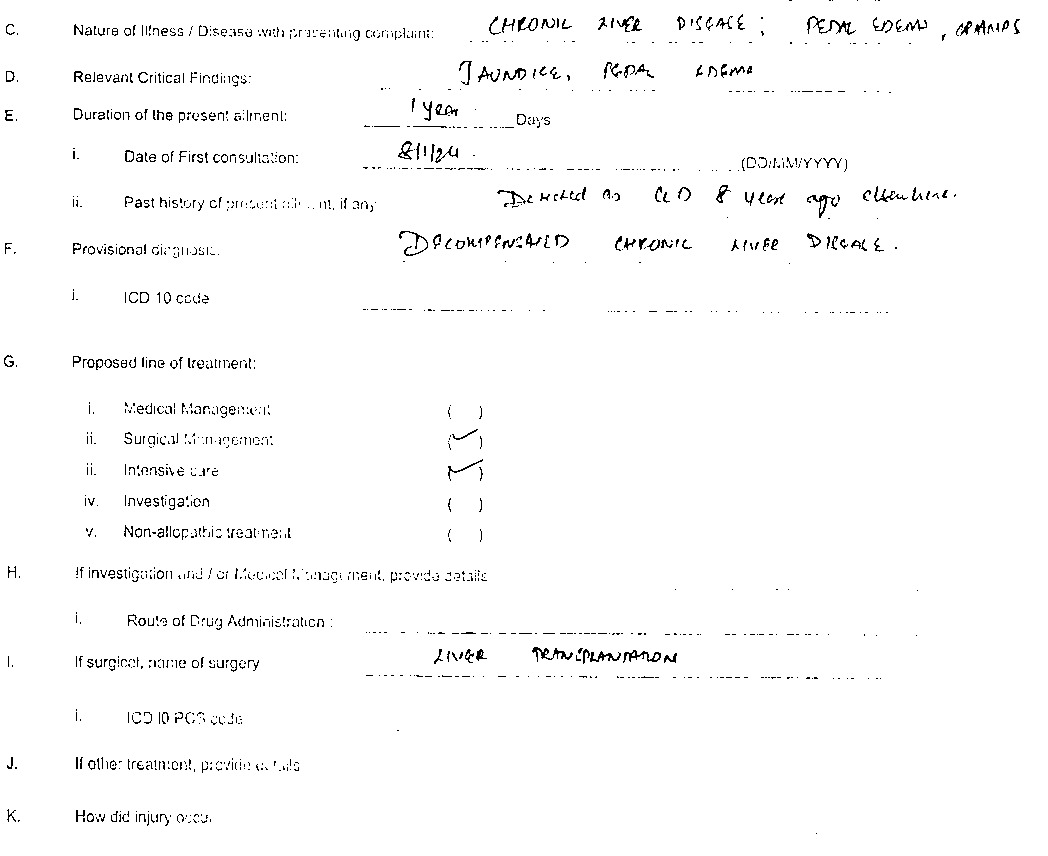

In [ ]:
# Extract text from preprocessed image
text_1 = pytesseract.image_to_string(img, lang="eng")
print(text_1)

C. Nature of Illness / Disease with presenting complaint: CHRONIC IVER DISEASE; PEDAL EDEMA ORAMPS f
D. Relevant Critical Findings: JAUNDICE, PEDAL EDEME
E. Duration of the present ailment: 1 year Days
i. Date of First consultation: 8/1/24.
(DD/MM/YYYY)
H. Past history of present allment, if any Detected as CAD & yeast ago elsewhere.
Provisional diagnosis: DECOMPENSATED CHRONIC IVER DIRGALE.
1. ICD 10 code
F.
G. Proposed line of treatment:
1. Medical Management
ii. Surgical Management
ii. Intensive care
iv. Investigation
()
V. Non-allopathic treatment ()
H. If Investigation and/or Medical Managernent, provide details
1. Route of Drug Administration:
If surgical, narne of surgery TRANSPLANTATION.
i. ICD 10 PCS code
J. If other treatment, provide details
K. How did injury occur

In [10]:
import re
from typing import Dict

# Function to return useful information in JSON format
def parse(text: str) -> Dict:
    return {
        "patient_name": get_field("patient_name", text),
        "patient_address": get_field("patient_address", text),
        "medicines": get_field("medicines", text),
        "directions": get_field("directions", text),
        "refill": get_field("refill", text),
        "diagnosis": get_field("diagnosis", text),
        "first_consultation": get_field("first_consultation", text),
        "treatment_plan": get_field("treatment_plan", text),
        "surgery_details": get_field("surgery_details", text)
    }

# Function to find useful information from the text using Regular Expressions
def get_field(field_name: str, text: str) -> str:
    pattern_dict = {
        "patient_name": {"pattern": "Name:(.*)Date", "flags": 0},
        "patient_address": {"pattern": "Address:(.*)\n", "flags": 0},
        "medicines": {"pattern": "Address:[^\n]*(.*)Directions", "flags": re.DOTALL},
        "directions": {"pattern": "Directions:.(.*)Refill", "flags": re.DOTALL},
        "refill": {"pattern": "Refill:.*(\d).*times", "flags": 0},
        "diagnosis": {"pattern": "Provisional diagnosis:(.*)ICD 10 code", "flags": re.DOTALL},
        "first_consultation": {"pattern": "Date of First consultation:(.*)\(DD/MM/YYYY\)", "flags": 0},
        "treatment_plan": {"pattern": "Proposed line of treatment:(.*)If Investigation", "flags": re.DOTALL},
        "surgery_details": {"pattern": "If surgical, narne of surgery(.*)\n", "flags": re.DOTALL}
    }

    pattern_object = pattern_dict.get(field_name)
    if pattern_object:
        matches = re.findall(pattern_object["pattern"], text, flags=pattern_object["flags"])
        if matches:
            return matches[0].strip()
    return ""


In [ ]:
# Let's get useful fields from our texts
text_list = [text_1, text_2]
for i in range(len(text_list)):
    print(f"Important fields from text {i+1}:\n")
    print(parse(text_list[i]))
    print("\n----------------------\n")

Important fields from text 1:

{
    'patient_name': '',
    'patient_address': '',
    'medicines': '',
    'directions': '',
    'refill': '',
    'diagnosis': 'DECOMPENSATED CHRONIC IVER DIRGALE.',
    'first_consultation': '8/1/24.',
    'treatment_plan': '1. Medical Management',
    'surgery_details': 'TRANSPLANTATION.'
}

----------------------

Important fields from text 2:

{
    'patient_name': '',
    'patient_address': '',
    'medicines': '',
    'directions': '',
    'refill': '',
    'diagnosis': 'STAGE 2 CARDIAC ARREST',
    'first_consultation': '15/3/23.',
    'treatment_plan': '1. Intensive care',
    'surgery_details': 'BYPASS SURGERY.'
}

----------------------
